# Notebook 3: Detecção de Anomalias com Autoencoder

## 1. Introdução

Este notebook aborda o problema de detecção de falhas do dataset SECOM sob uma nova perspectiva: **Detecção de Anomalias**.

### 1.1. Contexto dos Notebooks Anteriores

Nos notebooks 1 e 2, tratamos o problema como uma tarefa de **classificação supervisionada**. Apesar de testarmos uma vasta gama de modelos (desde Regressão Logística até Redes Neurais otimizadas), o resultado foi consistente: os modelos falharam em aprender um padrão robusto para a classe de "falha" (minoritária), devido ao sinal preditivo extremamente fraco e ao severo desbalanceamento dos dados.

### 1.2. Nova Hipótese: Detecção de Anomalias com Autoencoder

A hipótese para este notebook é: **E se, em vez de ensinar ao modelo a diferença entre "bom" e "ruim", nós o ensinarmos a ser um especialista em "bom"?**

Usaremos um tipo de rede neural chamado **Autoencoder**. O plano é o seguinte:
1.  **Treinamento Exclusivo:** Treinaremos o Autoencoder **apenas com dados de sucesso (normais)**. O modelo aprenderá a reconstruir com alta fidelidade o padrão de um sensor de uma peça boa.
2.  **Detecção por Erro de Reconstrução:** Quando apresentarmos ao modelo treinado um dado que ele nunca viu:
    * Se for de uma **peça boa**, ele conseguirá reconstruí-la facilmente, gerando um **erro de reconstrução baixo**.
    * Se for de uma **peça com falha (anomalia)**, o padrão será diferente do que ele aprendeu. Ele terá dificuldade em reconstruí-la, gerando um **erro de reconstrução alto**.
3.  **Definição de um Limiar:** Definiremos um limiar de erro. Qualquer peça cujo erro de reconstrução ultrapasse esse limiar será classificada como uma anomalia.

### 1.3. Plano de Ação
1.  **Setup e Carregamento:** Carregar o dataset limpo do Notebook 1.
2.  **Preparação dos Dados:** Criar um conjunto de treino contendo **apenas dados normais** e um conjunto de teste contendo dados normais e todas as anomalias.
3.  **Construção e Treinamento do Autoencoder.**
4.  **Análise do Erro:** Calcular o erro de reconstrução para todos os dados de teste e encontrar um limiar para separar o normal do anômalo.
5.  **Avaliação Final:** Gerar a matriz de confusão e o relatório de classificação para esta nova abordagem.

In [1]:
# ==============================================================================
# CÉLULA DE CÓDIGO 1: SETUP E PREPARAÇÃO DOS DADOS PARA ANOMALY DETECTION
# ==============================================================================

# 1.1. Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Configurações
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
print("✅ Bibliotecas importadas com sucesso!")

# 1.2. Upload e Carregamento do Dataset Limpo
print("\nPor favor, selecione o arquivo 'secom_cleaned_dataset.csv'.")
uploaded = files.upload()
filename = next(iter(uploaded))

if filename:
    print(f"\nArquivo '{filename}' recebido. Carregando em DataFrame...")
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
    print("✅ Carga de dados concluída!")
else:
    print("\n‼️ ERRO: Nenhum arquivo foi enviado.")


# 1.3. Preparação dos Dados para o Autoencoder
# Esta é a etapa mais CRÍTICA e diferente.

# Separar os dados normais e as anomalias
df_normal = df[df['Pass/Fail'] == -1]
df_anomaly = df[df['Pass/Fail'] == 1]

print(f"\nTotal de amostras normais: {len(df_normal)}")
print(f"Total de anomalias: {len(df_anomaly)}")

# Criar features e labels
X_normal = df_normal.drop(columns=['Time', 'Pass/Fail'])
X_anomaly = df_anomaly.drop(columns=['Time', 'Pass/Fail'])
y_anomaly = df_anomaly['Pass/Fail'].replace({-1: 0, 1: 1}) # Labels 0/1 para avaliação

# Dividir os dados NORMAIS em treino e teste. O treino do autoencoder SÓ USA DADOS NORMAIS.
# Usaremos 80% dos dados normais para treinar o autoencoder.
X_train_normal, X_test_normal, _, _ = train_test_split(
    X_normal, X_normal, # y não é necessário aqui
    test_size=0.2,
    random_state=42
)

# O nosso conjunto de teste final será composto pelos 20% restantes dos dados normais
# MAIS TODAS as anomalias.
X_test = pd.concat([X_test_normal, X_anomaly])
# Criar as labels correspondentes para o conjunto de teste
y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_anomaly))])


# 1.4. Escalonamento das Features
# Ajustamos (fit) o scaler APENAS nos dados de treino (que são 100% normais)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

print("\n--- Preparação de dados para Detecção de Anomalias concluída ---")
print(f"Shape do conjunto de treino (apenas dados normais): {X_train_scaled.shape}")
print(f"Shape do conjunto de teste (normais + anomalias): {X_test_scaled.shape}")
print(f"Distribuição de classes no conjunto de teste: {pd.Series(y_test).value_counts()}")
print("\n✅ Dados prontos para construir e treinar o Autoencoder.")

✅ Bibliotecas importadas com sucesso!

Por favor, selecione o arquivo 'secom_cleaned_dataset.csv'.


Saving secom_cleaned_dataset.csv to secom_cleaned_dataset.csv

Arquivo 'secom_cleaned_dataset.csv' recebido. Carregando em DataFrame...
✅ Carga de dados concluída!

Total de amostras normais: 1463
Total de anomalias: 104

--- Preparação de dados para Detecção de Anomalias concluída ---
Shape do conjunto de treino (apenas dados normais): (1170, 558)
Shape do conjunto de teste (normais + anomalias): (397, 558)
Distribuição de classes no conjunto de teste: 0.0    293
1.0    104
Name: count, dtype: int64

✅ Dados prontos para construir e treinar o Autoencoder.


### 2. Construção e Treinamento do Autoencoder

Agora vamos construir nossa rede neural de Autoencoder usando TensorFlow/Keras. A arquitetura será simétrica:

1.  **Encoder:** Uma série de camadas que comprime os dados de entrada (558 features) em uma representação latente de baixa dimensão (o "bottleneck" ou gargalo). Isso força o modelo a aprender apenas as características mais essenciais dos dados normais.
2.  **Decoder:** Uma série de camadas que pega a representação comprimida e tenta reconstruir o dado de entrada original com a maior fidelidade possível.

O modelo será treinado **exclusivamente com os dados normais** (`X_train_scaled`), com o objetivo de minimizar o erro de reconstrução, que mediremos com o Erro Absoluto Médio (`mae`).

In [2]:
# ==============================================================================
# CÉLULA DE CÓDIGO 2: CONSTRUÇÃO E TREINAMENTO DO AUTOENCODER
# ==============================================================================
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Para garantir reprodutibilidade
tf.random.set_seed(42)

# 3.1. Definição da Arquitetura
input_dim = X_train_scaled.shape[1]
latent_dim = 32 # Tamanho do nosso 'gargalo' (bottleneck)

autoencoder = Sequential([
    # --- Encoder ---
    # Camada de entrada
    Input(shape=(input_dim,)),
    # Camadas de compressão
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(latent_dim, activation='relu'), # A representação comprimida

    # --- Decoder ---
    # Camadas de reconstrução
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    # Camada de saída - deve ter o mesmo número de neurônios da entrada
    Dense(input_dim, activation=None) # Sem ativação para permitir valores positivos/negativos
])

# 3.2. Compilação do Modelo
autoencoder.compile(optimizer='adam', loss='mae') # Erro Absoluto Médio

print("--- Arquitetura do Autoencoder ---")
autoencoder.summary()

# 3.3. Definição do Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Uma paciência menor é suficiente aqui
    verbose=1,
    restore_best_weights=True
)

# 3.4. Treinamento do Autoencoder
print("\n--- Iniciando o treinamento do Autoencoder ---")
# IMPORTANTE: O modelo aprende a reconstruir a si mesmo.
# Por isso, X_train_scaled é passado como entrada (x) e como alvo (y).
history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled, # Alvo é a própria entrada
    epochs=150,
    batch_size=32,
    validation_split=0.2, # Usar 20% dos dados de treino para validação interna
    callbacks=[early_stopping],
    verbose=1
)

print("\n✅ Treinamento concluído. O Autoencoder agora é um 'especialista' em dados normais.")

--- Arquitetura do Autoencoder ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        71,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 558)            │        71,982 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,302 (641.80 KB)

 Trainable params: 164,302 (641.80 KB)

 Non-trainable params: 0 (0.00 B)


--- Iniciando o treinamento do Autoencoder ---
Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.4906 - val_loss: 0.4685
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4724 - val_loss: 0.4594
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4634 - val_loss: 0.4541
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4568 - val_loss: 0.4480
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4503 - val_loss: 0.4416
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4434 - val_loss: 0.4372
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4382 - val_loss: 0.4348
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4351 - val_loss: 0.4321
Epoch 9/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4330 - val_loss: 0.4315
Epoch 10/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4313 - val_loss: 0.4303
Epoch 11/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4287 - val_loss: 0.4260
Epoch 12/150
3

### 3. Avaliação do Modelo e Detecção de Anomalias

Com o autoencoder treinado para ser um especialista em dados "normais", vamos agora usá-lo para inspecionar nosso conjunto de teste, que contém tanto dados normais quanto anomalias.

O processo de avaliação consiste em:
1.  **Obter as Reconstruções:** Passar os dados de teste (`X_test_scaled`) pelo autoencoder para gerar suas versões reconstruídas.
2.  **Calcular o Erro de Reconstrução:** Para cada amostra de teste, calcular o Erro Absoluto Médio (MAE) entre a entrada original e sua reconstrução. A nossa hipótese é que as anomalias terão um erro significativamente maior.
3.  **Analisar a Distribuição dos Erros:** Visualizar os erros para as classes normal e anômala para confirmar se eles são separáveis.
4.  **Definir um Limiar de Anomalia:** Estabelecer um "limiar de erro". Qualquer amostra com erro acima deste limiar será classificada como uma anomalia (falha).
5.  **Avaliar o Classificador:** Gerar o relatório de classificação e a matriz de confusão para ver a performance do nosso detector de anomalias.

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step
--- Reconstruções do conjunto de teste geradas ---

--- Análise da Distribuição dos Erros de Reconstrução ---


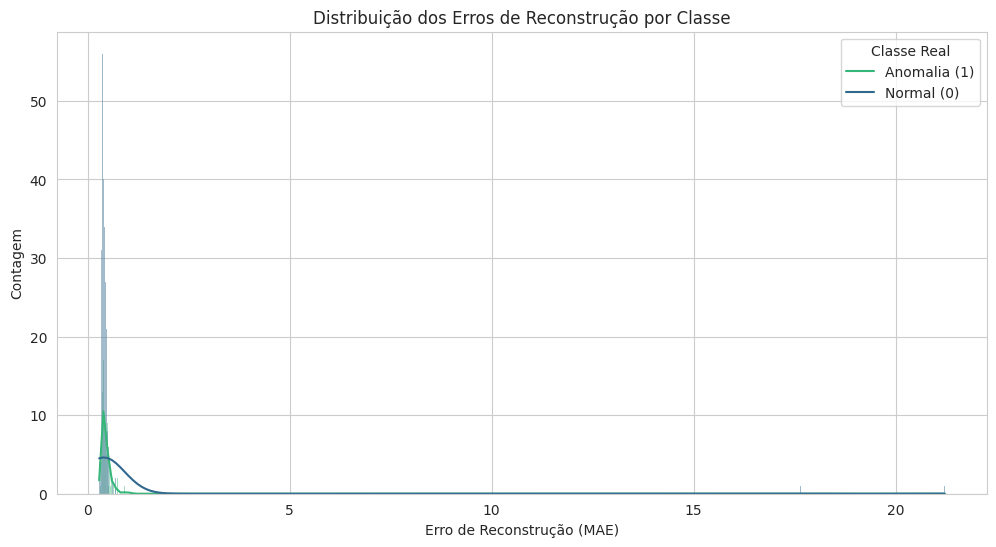

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Limiar de anomalia definido em: 0.6068
(Qualquer amostra com erro de reconstrução acima deste valor será uma anomalia)

--- Resultados da Avaliação (Detector de Anomalias) ---

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.75      0.97      0.84       293
         1.0       0.44      0.07      0.12       104

    accuracy                           0.73       397
   macro avg       0.59      0.52      0.48       397
weighted avg       0.66      0.73      0.65       397


Matriz de Confusão:


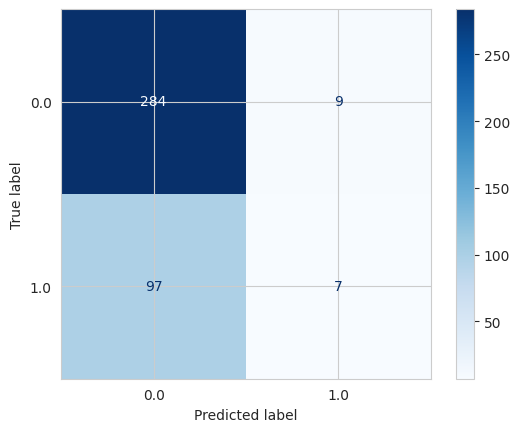

In [3]:
# ==============================================================================
# CÉLULA DE CÓDIGO 3: AVALIAÇÃO E DETECÇÃO DE ANOMALIAS
# ==============================================================================
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 4.1. Obter as Reconstruções do Conjunto de Teste
reconstructions = autoencoder.predict(X_test_scaled)
print("--- Reconstruções do conjunto de teste geradas ---")


# 4.2. Calcular o Erro de Reconstrução para cada Amostra
# Usamos o Erro Absoluto Médio (mae) para cada linha
test_loss = tf.keras.losses.mae(reconstructions, X_test_scaled)

# Criar um DataFrame para facilitar a análise dos erros
error_df = pd.DataFrame({
    'reconstruction_error': test_loss,
    'true_class': y_test # y_test já está no formato 0 (normal) e 1 (anomalia)
})


# 4.3. Análise da Distribuição dos Erros
print("\n--- Análise da Distribuição dos Erros de Reconstrução ---")
plt.figure(figsize=(12, 6))
sns.histplot(data=error_df, x='reconstruction_error', hue='true_class', palette='viridis', kde=True)
plt.title('Distribuição dos Erros de Reconstrução por Classe')
plt.xlabel('Erro de Reconstrução (MAE)')
plt.ylabel('Contagem')
plt.legend(title='Classe Real', labels=['Anomalia (1)', 'Normal (0)'])
plt.show()


# 4.4. Definição de um Limiar (Threshold) de Anomalia
# Uma abordagem comum é definir o limiar com base na distribuição dos erros de TREINO.
# Vamos calcular o erro médio + um número de desvios padrão dos dados de treino.
train_reconstructions = autoencoder.predict(X_train_scaled)
train_loss = tf.keras.losses.mae(train_reconstructions, X_train_scaled)

threshold = np.mean(train_loss) + 3 * np.std(train_loss)
print(f"\nLimiar de anomalia definido em: {threshold:.4f}")
print("(Qualquer amostra com erro de reconstrução acima deste valor será uma anomalia)")


# 4.5. Avaliar o Classificador
# Classificar como anomalia (1) se o erro for maior que o limiar
y_pred = (error_df['reconstruction_error'] > threshold).astype(int)

print("\n--- Resultados da Avaliação (Detector de Anomalias) ---\n")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusão:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

### 4. Encontrando o Limiar Ideal: Análise de Trade-off

A análise anterior mostrou que nosso detector de anomalias, com um limiar estatístico, alcançou uma ótima precisão, mas com um recall muito baixo (perdeu muitas falhas).

Nesta etapa final, vamos explorar manualmente diferentes limiares de decisão. O objetivo é encontrar um "ponto de equilíbrio" que se ajuste melhor a uma necessidade de negócio, onde provavelmente é aceitável ter alguns alarmes falsos a mais em troca de detectar uma porcentagem maior das falhas reais.

1.  **Visualizar a Curva Precisão-Recall:** Para ter uma visão geral de todas as possibilidades de trade-off.
2.  **Testar Limiares Específicos:** Vamos simular os resultados para alguns limiares mais "agressivos" (mais baixos) e analisar as métricas e a matriz de confusão para cada um.

--- Curva de Precisão-Recall ---


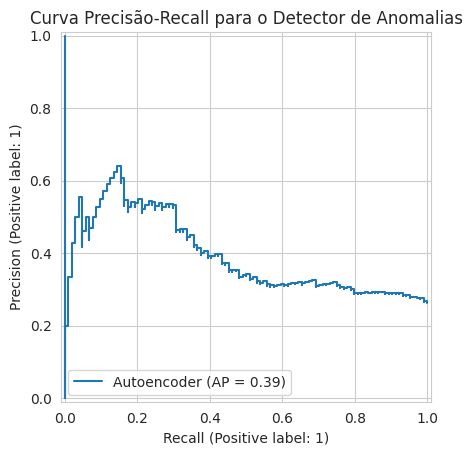


--- Simulação com Diferentes Limiares de Decisão ---

================== RESULTADOS PARA O LIMIAR >= 0.35 ==================
Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.87      0.16      0.28       293
         1.0       0.28      0.93      0.43       104

    accuracy                           0.37       397
   macro avg       0.58      0.55      0.36       397
weighted avg       0.72      0.37      0.32       397

Matriz de Confusão:


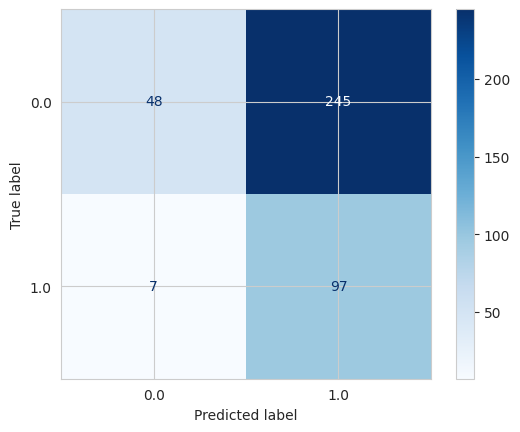

================== RESULTADOS PARA O LIMIAR >= 0.40 ==================
Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.78      0.57      0.66       293
         1.0       0.32      0.56      0.40       104

    accuracy                           0.57       397
   macro avg       0.55      0.56      0.53       397
weighted avg       0.66      0.57      0.59       397

Matriz de Confusão:


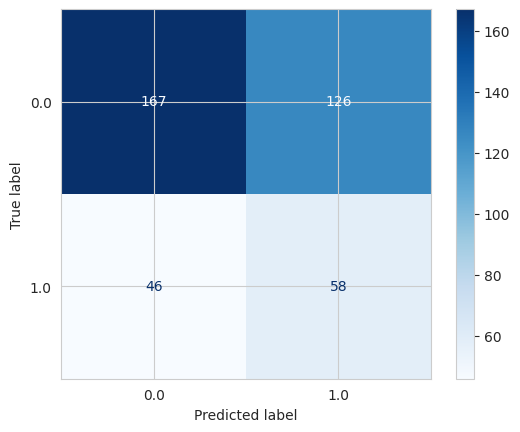

================== RESULTADOS PARA O LIMIAR >= 0.45 ==================
Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81       293
         1.0       0.45      0.36      0.40       104

    accuracy                           0.72       397
   macro avg       0.62      0.60      0.60       397
weighted avg       0.70      0.72      0.70       397

Matriz de Confusão:


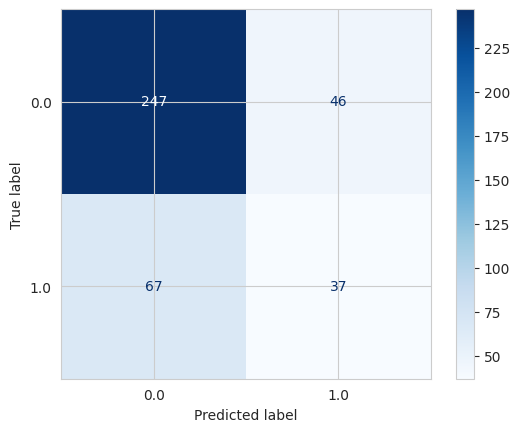

================== RESULTADOS PARA O LIMIAR >= 0.50 ==================
Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.76      0.94      0.84       293
         1.0       0.51      0.17      0.26       104

    accuracy                           0.74       397
   macro avg       0.64      0.56      0.55       397
weighted avg       0.70      0.74      0.69       397

Matriz de Confusão:


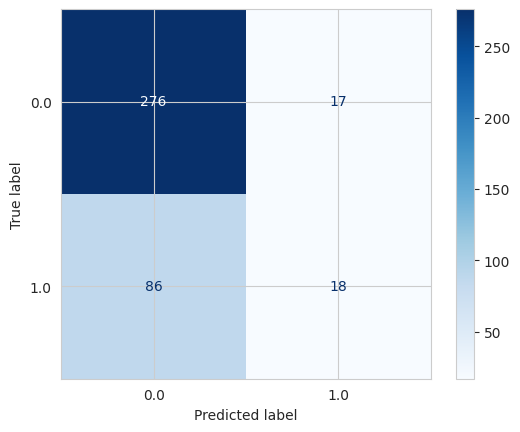

In [4]:
# ==============================================================================
# CÉLULA DE CÓDIGO 4: ANÁLISE E AJUSTE FINO DO LIMIAR DE ANOMALIA
# ==============================================================================
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, classification_report, ConfusionMatrixDisplay

# 5.1. Plotar a Curva de Precisão-Recall
# Isso nos dá uma visão geral de todos os trade-offs possíveis.
# Usamos o erro de reconstrução como o "score" da previsão.
print("--- Curva de Precisão-Recall ---")
display = PrecisionRecallDisplay.from_predictions(y_test, error_df['reconstruction_error'], name="Autoencoder")
_ = display.ax_.set_title("Curva Precisão-Recall para o Detector de Anomalias")
plt.show()


# 5.2. Simular o Desempenho com Diferentes Limiares
print("\n--- Simulação com Diferentes Limiares de Decisão ---\n")

# Olhando o gráfico de distribuição anterior, os erros das anomalias parecem mais concentrados
# na faixa de 0.3 a 0.6. Vamos testar valores nessa região.
thresholds_to_test = [0.35, 0.40, 0.45, 0.50]

for thresh in thresholds_to_test:
    # Aplicar o novo limiar para obter as novas previsões
    y_pred_new = (error_df['reconstruction_error'] > thresh).astype(int)

    print(f"================== RESULTADOS PARA O LIMIAR >= {thresh:.2f} ==================")
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred_new))
    print("Matriz de Confusão:")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_new, cmap='Blues')
    plt.show()

### 5. Salvando o Modelo Autoencoder

Como etapa final deste projeto, vamos salvar o modelo `autoencoder` treinado.

Isso nos permitirá carregar e reutilizar este detector de anomalias em outras aplicações ou notebooks no futuro, sem a necessidade de passar por todo o processo de treinamento novamente. O modelo completo (arquitetura e pesos) será salvo em um arquivo `.keras` e baixado para o seu computador.

In [5]:
# ==============================================================================
# CÉLULA DE CÓDIGO 5: SALVAR E BAIXAR O MODELO AUTOENCODER
# ==============================================================================
from google.colab import files

# Nome do arquivo para o modelo salvo
model_filename = 'secom_autoencoder_model.keras'

print(f"Salvando o modelo autoencoder treinado no arquivo: {model_filename}")

# Salva o modelo completo
autoencoder.save(model_filename)

print("Modelo salvo com sucesso no ambiente do Colab.")
print("Iniciando o download para o seu computador...")

# Comando para iniciar o download do arquivo no seu navegador
files.download(model_filename)

Salvando o modelo autoencoder treinado no arquivo: secom_autoencoder_model.keras
Modelo salvo com sucesso no ambiente do Colab.
Iniciando o download para o seu computador...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 6. Salvando os Artefatos Finais do Projeto

Como etapa final e conclusiva, vamos salvar todos os artefatos importantes deste experimento:

1.  **O Modelo Treinado (`.keras`):** O arquivo binário contendo a arquitetura e os pesos do nosso Autoencoder.
2.  **Metadados do Treinamento (`.json`):** Um arquivo de texto contendo informações cruciais sobre o treinamento e a configuração final, como:
    * O histórico de perda (`loss`) e perda de validação (`val_loss`) para cada época.
    * O limiar de anomalia escolhido como o mais equilibrado (`0.45`).
    * A performance final do modelo (Recall e Precisão) com esse limiar.

Isso garante que qualquer pessoa (ou você mesmo, no futuro) possa entender e reproduzir os resultados deste notebook.

In [6]:
# ==============================================================================
# CÉLULA DE CÓDIGO 6: SALVAR E BAIXAR MODELO E METADADOS
# ==============================================================================
import json
from google.colab import files

# 7.1. Preparar os Metadados para Salvar
final_threshold = 0.45

# Vamos recalcular as métricas para o nosso limiar escolhido para salvá-las
y_pred_final = (error_df['reconstruction_error'] > final_threshold).astype(int)
final_report = classification_report(y_test, y_pred_final, output_dict=True)

# O histórico do Keras pode conter valores float32 que não são serializáveis em JSON
# Vamos convertê-los para float padrão.
history_dict = {key: [float(i) for i in value] for key, value in history.history.items()}

metadata = {
    "project_name": "SECOM Anomaly Detection",
    "model_type": "Autoencoder",
    "final_anomaly_threshold": final_threshold,
    "training_history": history_dict,
    "final_performance_on_test_set": {
        "precision_for_anomaly": final_report['1.0']['precision'],
        "recall_for_anomaly": final_report['1.0']['recall'],
        "f1_score_for_anomaly": final_report['1.0']['f1-score'],
        "accuracy": final_report['accuracy']
    }
}

# Nomes dos arquivos
model_filename = 'secom_autoencoder_model.keras'
metadata_filename = 'secom_autoencoder_metadata.json'

# 7.2. Salvar o Arquivo de Metadados
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"Metadados do treinamento salvos em: {metadata_filename}")


# 7.3. Salvar o Modelo Keras
autoencoder.save(model_filename)
print(f"Modelo salvo em: {model_filename}")


# 7.4. Baixar os Arquivos
print("\nIniciando o download dos artefatos para o seu computador...")
files.download(model_filename)
files.download(metadata_filename)

Metadados do treinamento salvos em: secom_autoencoder_metadata.json
Modelo salvo em: secom_autoencoder_model.keras

Iniciando o download dos artefatos para o seu computador...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>